In [5]:
import numpy as np
import pysam
from scipy import stats


In [64]:
##get data
in_bed='/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/DNA_IMR90_rep2_merged.b37.calmd.cytosine.filtered.sort.GCH.strand.6plus2.chr20.bed.gz'
tbx = pysam.TabixFile(in_bed)
methy_list = []
pos_list = []
for line in tbx.fetch('20', 0, 63025520):
    splitline = line.split("\t")
    pos = int(splitline[2])
    m = (100.0-float(splitline[6]))/100
    c = int(splitline[7])
    if c >= 3:
        methy_list.append(m)
        pos_list.append(pos)
methy_list = np.array(methy_list, dtype='float')
pos_list = np.array(pos_list, dtype='int')
methy_list = stats.zscore(methy_list)
methy_list.shape



(2463135,)

In [22]:
from scipy.stats import distributions

# Sample parameters
nsamples = 1000
mu1_true = 0.3
mu2_true = 0.55
sig1_true = 0.08
sig2_true = 0.12
a_true = 0.4

# Samples generation
np.random.seed(3)  # for repeatability
bins = np.arange(-4, 2, 0.05)
data, _ = np.histogram(methy_list, bins=bins, density=True)
x_data = bins[:-1] + 0.5*(bins[1] - bins[0])

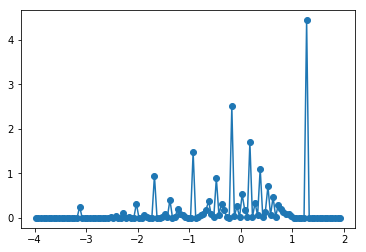

In [23]:
from scipy.stats import distributions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.plot(x_data, data, '-o');

In [154]:
import lmfit

peak1 = lmfit.models.GaussianModel(prefix='p1_') # strong TFBS peaks
peak2 = lmfit.models.GaussianModel(prefix='p2_') # weak TFBS peaks
peak3 = lmfit.models.GaussianModel(prefix='p3_') # nucleosome peaks
peak4 = lmfit.models.GaussianModel(prefix='p4_') # background linker
peak5 = lmfit.models.GaussianModel(prefix='p5_') # NDR
model = peak1 + peak2 + peak3 + peak4 + peak5

model.set_param_hint('p1_center', value=1.2, min=-4, max=2)
model.set_param_hint('p2_center', value=0.8, min=-4, max=2)
model.set_param_hint('p3_center', value=0.3, min=-4, max=2)
model.set_param_hint('p4_center', value=-0.5, min=-4, max=2)
model.set_param_hint('p5_center', value=-2, min=-4, max=2)
model.set_param_hint('p1_sigma', value=0.1, min=0.01, max=0.3)
model.set_param_hint('p2_sigma', value=0.1, min=0.01, max=0.3)
model.set_param_hint('p3_sigma', value=0.1, min=0.01, max=0.3)
model.set_param_hint('p4_sigma', value=0.5, min=0.01, max=5)
model.set_param_hint('p5_sigma', value=0.1, min=0.01, max=0.3)
model.set_param_hint('p1_amplitude', value=0.05, min=0.0, max=1)
model.set_param_hint('p2_amplitude', value=0.05, min=0.0, max=1)
model.set_param_hint('p3_amplitude', value=0.35, min=0.0, max=1)
model.set_param_hint('p4_amplitude', value=0.5, min=0.0, max=1)
model.set_param_hint('p5_amplitude', value=0.05, min=0.0, max=1)
name = '5-gaussians'


In [155]:
fit_res = model.fit(data, x=x_data)
print(fit_res.fit_report())


[[Model]]
    ((((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(gaussian, prefix='p3_')) + Model(gaussian, prefix='p4_')) + Model(gaussian, prefix='p5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2677
    # data points      = 119
    # variables        = 15
    chi-square         = 9.22974181
    reduced chi-square = 0.08874752
    Akaike info crit   = -274.246398
    Bayesian info crit = -232.559545
[[Variables]]
    p1_amplitude:  0.14785549 +/- 0.59052829 (399.40%) (init = 0.05)
    p1_center:     1.27568647 +/- 0.20427286 (16.01%) (init = 1.2)
    p1_sigma:      0.01329058 +/- 0.05596302 (421.07%) (init = 0.1)
    p2_amplitude:  0.08310344 +/- 0.13544134 (162.98%) (init = 0.05)
    p2_center:     0.51946312 +/- 0.12935205 (24.90%) (init = 0.8)
    p2_sigma:      0.14989764 +/- 0.17673524 (117.90%) (init = 0.1)
    p3_amplitude:  0.03758599 +/- 17.2522088 (45900.64%) (init = 0.35)
    p3_center:     0.17511009 +/- 20.94505

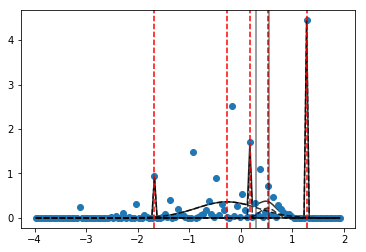

In [156]:
fig, ax = plt.subplots()
x = x_data
ax.plot(x, model.eval(x=x, **fit_res.values), 'k', alpha=0.8)
plt.plot(x_data, data, 'o');
if  fit_res.model.components is not None:
    for component in fit_res.model.components:
        ax.plot(x, component.eval(x=x, **fit_res.values), '--k',
                alpha=0.8)
for param in ['p1_center', 'p2_center', 'p3_center', 'p4_center', 'p5_center']:
    ax.axvline(fit_res.params[param].value, ls='--', color='r')
ax.axvline(mu1_true, color='k', alpha=0.5)
ax.axvline(mu2_true, color='k', alpha=0.5)


In [157]:
prob_list_comp1 = fit_res.model.components[0].eval(x=methy_list, **fit_res.values)
prob_list_comp2 = fit_res.model.components[1].eval(x=methy_list, **fit_res.values)
prob_list_comp3 = fit_res.model.components[2].eval(x=methy_list, **fit_res.values)
prob_list_comp4 = fit_res.model.components[3].eval(x=methy_list, **fit_res.values)
prob_list_comp5 = fit_res.model.components[4].eval(x=methy_list, **fit_res.values)
prob_list = np.column_stack((prob_list_comp1, prob_list_comp2, prob_list_comp3, prob_list_comp4, prob_list_comp5))

In [158]:
prob_sum = np.sum(prob_list,axis=1)
prob_list_norm = np.column_stack((prob_list[:,0]/prob_sum, prob_list[:,1]/prob_sum, prob_list[:,2]/prob_sum, prob_list[:,3]/prob_sum, prob_list[:,4]/prob_sum))
prob_list_norm[0:10,]

array([[0.00000000e+00, 9.51130051e-03, 8.10131440e-01, 1.80357259e-01,
        0.00000000e+00],
       [0.00000000e+00, 4.37191213e-01, 1.59069618e-88, 5.62808787e-01,
        0.00000000e+00],
       [0.00000000e+00, 9.51130051e-03, 8.10131440e-01, 1.80357259e-01,
        0.00000000e+00],
       [9.96997158e-01, 1.75931711e-07, 0.00000000e+00, 3.00266642e-03,
        0.00000000e+00],
       [0.00000000e+00, 9.51130051e-03, 8.10131440e-01, 1.80357259e-01,
        0.00000000e+00],
       [0.00000000e+00, 4.87695721e-21, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00],
       [9.96997158e-01, 1.75931711e-07, 0.00000000e+00, 3.00266642e-03,
        0.00000000e+00],
       [0.00000000e+00, 9.51130051e-03, 8.10131440e-01, 1.80357259e-01,
        0.00000000e+00],
       [9.96997158e-01, 1.75931711e-07, 0.00000000e+00, 3.00266642e-03,
        0.00000000e+00],
       [0.00000000e+00, 8.71603702e-11, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00]])

In [159]:
row_encode = np.argmax(prob_list_norm, axis=1)
row_encode[0:10]

array([2, 3, 2, 0, 2, 3, 0, 2, 0, 3])

In [160]:
with open('/Users/yaping/Documents/workspace/project/hexaseq/bulk_dna_rna_20201214/accessibility/DNA_IMR90_rep2_merged.row_encode_4GMM.b37.bedgraph','w') as out:
    for i in range(len(pos_list)):
        out.write('20' + '\t' + str(pos_list[i]-1) + '\t' + str(pos_list[i]) + '\t' + str(row_encode[i]) + '\n')


In [161]:
pos_list[0:10]


array([60199, 60200, 60202, 60203, 60215, 60221, 60222, 60226, 60227,
       60232])